<a href="https://colab.research.google.com/github/hyunjune123/Q-trader/blob/master/lstm_qtrader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Library

In [1]:
pip install alpha_vantage

     |████████████████████████████████| 1.3MB 6.9MB/s 
     |████████████████████████████████| 143kB 16.1MB/s 
     |████████████████████████████████| 296kB 17.0MB/s 
  Created wheel for alpha-vantage: filename=alpha_vantage-2.2.0-cp36-none-any.whl size=25706 sha256=8d7d19884981d7eec00fcb4dc5a9a6e31edf3a0161d801480144f6e63238f806
  Stored in directory: /root/.cache/pip/wheels/3a/fa/05/80b0afcbd2a4de8bd2a0c5cd77084e3d3a9cc12c48be9b7f84
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3161 sha256=58c4daab3a04d0b6f50096d226d40b97f9df78999c86dfe2414ae63f6ede8ac1
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built alpha-vantage idna-ssl


In [2]:
# Libraries used
import random
from datetime import datetime
import time
import pickle as pk
import os
import pdb

import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.initializers import glorot_uniform, Constant
from keras.regularizers import l2
import keras.backend as K
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import tensorflow as tf

import numpy as np
import pandas as pd
import math


from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from IPython.display import Image

import alpha_vantage
from alpha_vantage.timeseries import TimeSeries

# Functions

In [62]:
def get_daily():
    #symb = "MSFT"
    symb = "AAPL"
    ts = TimeSeries(key=api_key, output_format='pandas')
    msft_df_full, meta_data = ts.get_daily_adjusted(symbol=symb, outputsize='full')
    msft_df_full = msft_df_full.drop(['4. close', '7. dividend amount', '8. split coefficient'], axis=1)

    msft_df_full.columns = ["Open", "High", "Low", "Close", "Volume"]
    msft_df_full = msft_df_full.iloc[::-1]
    return msft_df_full

def get_intraday(inter):
    symb = "MSFT"
    ts = TimeSeries(key=api_key, output_format='pandas')
    msft_df_full, meta_data = ts.get_intraday(symbol=symb, outputsize='full', interval = inter)
    #msft_df_full = msft_df_full.drop(['4. close', '7. dividend amount', '8. split coefficient'], axis=1)

    msft_df_full.columns = ["Open", "High", "Low", "Close", "Volume"]
    msft_df_full = msft_df_full.iloc[::-1]
    return msft_df_full

def ewm_display(msft_df):
    fig, (ax1, ax2) = plt.subplots(2)
    close = (msft_df['Close'])[100:200]
    x = list(range(0, len(close)))
    y = close
    ax1.plot(x,y)
    ax1.set_title = "Simple harmonic motion stock price"
    ax1.set_xlabel = "Timestep"
    ax1.set_ylabel = 'Price'
    y = (y.ewm(com = 20)).mean()
    ax2.plot(x,y)
    ax2.set_title = "Simple harmonic motion stock price"
    ax2.set_xlabel = "Timestep"
    ax2.set_ylabel = 'Price'
    plt.show()

def state_rp(msft_df, window):
    train_len = int(len(msft_df)*0.9) 
    ex_prices = msft_df['Close_ex'].values
    prices = msft_df['Close'].values
    X_train = []
    y_train = []
    prices = []
    for i in range(window, len(msft_df)):
        prices += [prices[i]]
        x = ex_prices[i-window:i]
        x = (x-np.mean(x))/np.std(x)
        X_train.append(x)
        y_train.append(trai[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y= np.reshape(y_train, (X_train.shape[0],2))

    return (X[0:train_len], y[0:train_len], X[train_len:], y[train_len:],
            prices[0:train_len], prices[train_len:])

def bin_state_rp (df, window):
    train_len = int(len(df)*0.9) 
    ex_prices = df['Close_ex'].values
    real_prices = df['Close'].values
    volumes = df['Volume_ex'].values
    X_train = []
    y_train = []
    prices = []
    for i in range(window, len(df)):
        prices += [real_prices[i-1]]
        x = ex_prices[i-window:i]
        v = volumes[i-window:i]
        x = (x-np.mean(x))/np.std(x)
        v = (x-np.mean(v))/np.std(v)
        xv = [[x[j], v[j]] for j in range(0, len(x))]
        X_train.append(xv)
        
        ys = []
        #for yi in range(i, i+1):
        if ex_prices[i] - ex_prices[i-1] < 0:
            y = [1,0]
        else:
            y = [0,1]
        y_train.append(y)

    X_train, y_train = np.array(X_train), np.array(y_train)
    X = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
    y= np.reshape(y_train, (X_train.shape[0],2))

    return (X_train, y_train, prices)

tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

def lstm(X_train, y_train, nest_step, epoch):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta = 0.0001,
                                              patience=5)
    split = len(X_train)-nest_step
    (X, X_val, y, y_val) = (X_train[0:split], X_train[split:], y_train[0:split], y_train[split:])


    model = Sequential()
    model.add(LSTM(units = 100, return_sequences = False, input_shape = (X.shape[1], X.shape[2])))
    #model.add(LSTM(units = 32, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history3 = model.fit(X, y, epochs = epoch, batch_size = 8,
                         validation_data=(X_val, y_val), callbacks = [callback])

    # print model acc
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history3.history['loss'], 'y', label='train loss')
    loss_ax.plot(history3.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper right')

    print(history3.history.keys())
    acc_ax.plot(history3.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history3.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper left')

    plt.show()
    model.save("lstm_model")
    return model

def plot_test(model_name, name, margin, X_test, P_test, t_i):
    model = load_model(model_name)
    low = 0.5 - margin
    hi = 0.5 + margin
    mypredict = model.predict(X_test)
    my_result = []
    my_trend = []
    for i in range(len(mypredict)):
        pred = (mypredict[i])[1]
        my_result.append(pred)
        if pred < low:
            my_trend += ["down"]
        elif pred > hi:
            my_trend += ["up"]
        else:
            my_trend += ["hold"]
    
    colors = {'down' : 'red', 'hold' : 'black', 'up' : 'blue'}
    legends = ['red', 'black', 'blue']

    fig, (ax1, ax2) = plt.subplots(2)
    ax1.scatter(list(range(0,len(P_test))), P_test,
                c = [colors[x] for x in my_trend],
                s=3)
    for xc in ([i for i in range(len(my_trend)) if my_trend[i] == "hold"]):
        ax1.axvline(x = xc, linestyle = '--', color = 'gainsboro')    
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in legends]
    labels = ['down', 'hold', 'up']
    ax1.legend(lines, labels,loc="lower right")
    ax1.set_title('LSTM model MSFT Backtest')
    ax1.set_ylabel("Price")

    ax2.plot(list(range(0,len(my_result))), my_result, linewidth=1)
    ax2.set_ylabel("Model Output")

    my_file = str(name)+"_lstm_backtest_"+str(t_i)+".png"
    fig.savefig(my_file)
    plt.close()

def plot_output(model, name, margin, X_test, P_test):
    if len(X_test) >= 500:
        X_tests = np.array_split(X_test, 5)
        P_tests = np.array_split(P_test, 5)
        for i in range(0, len(X_tests)):
            plot_test(model, name, margin, X_tests[i], P_tests[i], i)
    else:
        plot_test(model, name, margin, X_test, P_test, 0)

def squeeze_strat(model_name, X, P, ws, hold_window, hold_per, margin, principal, name):
    model = load_model(model_name)
    low = 0.5 - margin
    hi = 0.5 + margin
    preds = [pred[1] for pred in model.predict(X)]
    inventory = 0 # number of stocks in position
    cash = principal
    trade_hist = pd.DataFrame(columns=['Price', 'Action', 'Inventory', 'Profit'])
    count = len([i for i in range(0, hold_window) if 0.5-margin < preds[i] < 0.5+margin])
    if count > hold_window * hold_per:
        status = "hold"
    else:
        status = "trend"
    status = "trend"
    for ti in range(hold_window, len(preds)):
        count = len([i for i in range(ti-hold_window, ti) if 0.5-margin < preds[i] < 0.5+margin])
        act = "None"
        p = (P)[ti]
        if count < hold_window * hold_per and status == "hold":
            certainty = np.average(preds[ti+1-len(ws):ti+1], weights=ws)
            if certainty > 0.5:
                act = "Sell"
                sell_q = int(certainty*inventory)
                inventory -= sell_q
                cash += sell_q*p
            else:
                act = "Buy"
                buy_q = min(int(certainty*principal), int(principal/p))
                inventory += buy_q
                cash -= buy_q*p
            status = "trend" # we are now in trend
        elif count > hold_window * hold_per and status == "trend":
            status = "hold"
        trade_hist.loc[ti] = [p, act, inventory, (cash+(inventory*p)-principal)/principal]
    trade_hist.to_csv(name+"_squeeze_backtest.csv")
    return trade_hist

def buysell_strat(model_name, X_test, P_test, margin, principal):
    model = load_model(model_name)
    low = 0.5 - margin
    hi = 0.5 + margin
    preds = [pred[1] for pred in model.predict(X_test)]
    inventory = 0 # number of stocks in position
    cash = principal
    trade_hist = pd.DataFrame(columns=['Price', 'Action', 'Inventory', 'Profit'])
    for ti in range(0, len(preds)):
        p = P_test[ti]
        act = "None"
        pred = preds[ti]
        if pred < 0.5-margin: 
            q = min(inventory, Int(cash/p))
            if inventory > q:
                act = "Sell"
                inventory -= q
                cash += p*q
        elif pred > 0.5+margin: 
            if cash > unit*q:
                act = "Buy"
                inventory += q
                cash -= p*q
        trade_hist.loc[ti] = [p, act, inventory, (cash+(inventory*p)-principal)/principal]
    trade_hist.to_csv("buysell_backtest.csv")
    return trade_hist

def hold_trade(model_name, X, P, margin, trend_window, principal, risk):
    model = load_model(model_name)
    risk += 1
    low = 0.5 - margin
    hi = 0.5 + margin
    preds = [pred[1] for pred in model.predict(X)]
    cash = principal
    init_p = P[0]
    inventory = int((principal/2) / init_p) # number of stocks in position
    cash = principal/2
    trends = []
    trade_hist = pd.DataFrame(columns=['Price', 'Action', 'trade','Inventory', 'Profit', 'Buyhold_Profit'])
    for ti in range(0, len(preds)):
        p = P[ti]
        act = "None"
        pred = preds[ti]
        trends += [pred]
        trade = 0
        if 0.5-margin < pred < 0.5+margin: # if we are at hold
            trend = np.mean(trends)
            if pred > 0.5 and trend < 0.5: #Buy
                act = "Buy"
                if cash > p: 
                    q = int((cash/p)*(pred-0.5)*risk)
                    inventory += q
                    cash -= p*q
                    trade = q
            elif pred < 0.5 and trend > 0.5: #Sell
                act = "Sell"
                if inventory > 0:
                    q = int(inventory*(0.5-pred)*risk)
                    cash += p*q
                    inventory -= q
                    trade = q
        if len(trends) > trend_window:
            trends = trends[1:]
        trade_hist.loc[ti] = [p, act, trade, inventory, (cash+(inventory*p)-principal)/principal,
                                  (p-init_p)/init_p]
    trade_hist.to_csv("tradehold_backtest.csv")
    return trade_hist
        


def plot_backtest(backtest, name):
    for index, row in backtest.iterrows():
        if row['Action'] == "Sell":
            plt.axvline(index, color = 'lightcoral', linewidth = 1)
        elif row['Action'] == "Buy":
            plt.axvline(index, color = 'lightskyblue', linewidth = 1)
    plt.plot([i for i in range(0, len(backtest))], backtest["Price"], color = 'k',
             alpha=0.9)
    c = {"Buy":"lightskyblue", "Sell":"lightcoral"}
    legends = ["Blue","Red"]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in legends]
    labels = ['Buy', 'Sell']
    plt.legend(lines, labels,loc="upper right")
    plt.show()
    plt.savefig(name+'.png')
    plt.close()



# Data collection

We collect data by using Alpha Vantage API. We can get free access by obtaining a key at https://www.alphavantage.co/support/#api-key. Put your obtained key in the first line in the code chunk below.

In [4]:
api_key = '8TMSJT1WD6USMGI1'

We can now fetch stock price data by using alpha vantage api. Documentation can be found in https://www.alphavantage.co/documentation/.
For this experiment we will use Microsoft's Daily Stock prices.

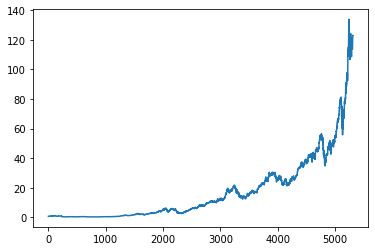

In [5]:
#msft_df = get_intraday("1min")
msft_df = get_daily()
#msft_df
plt.plot([i for i in range(0, len(msft_df))],msft_df['Close'])
plt.show()


We apply exponential smoothing to price and volume columns to remove noises that deviate from general trend. Below is an example of exponential smoothing.

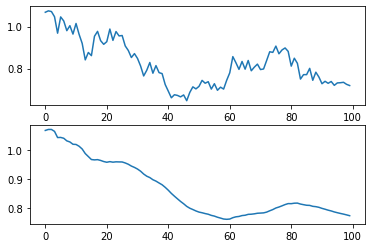

In [6]:
ewm_display(msft_df)

In [7]:
msft_df['Close_ex'] = ((msft_df['Close']).ewm(com = 20)).mean()
msft_df['Volume_ex'] = ((msft_df['Volume']).ewm(com = 20)).mean()

# Input Data Pre-processing

We plan to use LSTM model for trend prediction. We have 4775 samples with 30-day timestep 2 features, so the input dimension is (4775, 30, 2). The model with output a label 0 if it expects a downtrend or 1 if it expectes an uptrend tomorrow.

In [8]:
(Xs, ys, prices) = bin_state_rp(msft_df, 30)
print(len(Xs), len(ys), len(prices))

5278 5278 5278


# Training the LSTM model

For specific model architecture / parameters, refer to the structure of the LSTM model in the function lstm() above in the functions section. Training process will take around 1 minutes.

Epoch 1/200
225/225 [==============================] - 3s 15ms/step - loss: 0.4874 - accuracy: 0.7733 - val_loss: 0.3801 - val_accuracy: 0.8500
Epoch 2/200
225/225 [==============================] - 3s 12ms/step - loss: 0.4115 - accuracy: 0.8217 - val_loss: 0.3059 - val_accuracy: 0.8550
Epoch 3/200
225/225 [==============================] - 3s 13ms/step - loss: 0.3777 - accuracy: 0.8378 - val_loss: 0.3193 - val_accuracy: 0.8650
Epoch 4/200
225/225 [==============================] - 3s 13ms/step - loss: 0.3619 - accuracy: 0.8533 - val_loss: 0.2957 - val_accuracy: 0.8700
Epoch 5/200
225/225 [==============================] - 3s 13ms/step - loss: 0.3411 - accuracy: 0.8611 - val_loss: 0.2896 - val_accuracy: 0.8850
Epoch 6/200
225/225 [==============================] - 3s 13ms/step - loss: 0.3277 - accuracy: 0.8672 - val_loss: 0.2766 - val_accuracy: 0.8750
Epoch 7/200
225/225 [==============================] - 3s 13ms/step - loss: 0.3105 - accuracy: 0.8722 - val_loss: 0.2683 - val_accuracy:

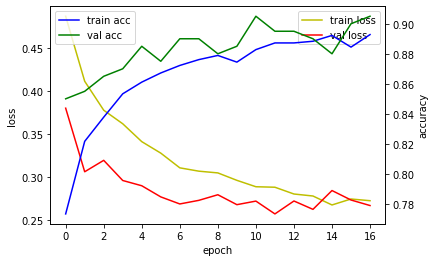

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: lstm_model/assets
--- 58.08976459503174 seconds ---


In [9]:
start_time = time.time()
inital_model = lstm(Xs[0:2000], ys[0:2000], 200, 200)
print("--- %s seconds ---" % (time.time() - start_time))

Both training and validation accuracy is about 90% when the loss is converged. The model has successfully learned to predict trend. 

# Strategy

We can come up with a trade strategy based on the model's prediction. The LSTM model's output tells us how certain the price is at either an up or down trend. We will exploit these output values to decide when and how much to enter / exit position.

The more the model output is closer to 1, we see that the price is in up-trend. When output is closer to 0, the price is in down-trend. The shaded region, which we will call the hold region, is where the model is uncertain about the trend. This is where the model output falls between the 0.5 +/- margin. We set the margin 0.4 for this experiment. 

In [13]:
plot_output("lstm_model", "train", 0.2, Xs[0:500],prices[0:500])

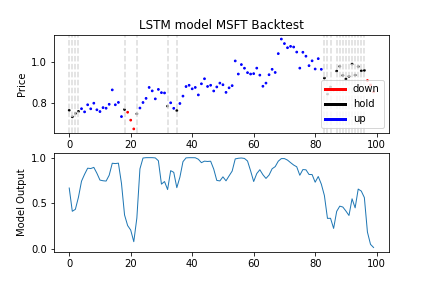

In [14]:
Image('train_lstm_backtest_0.png')

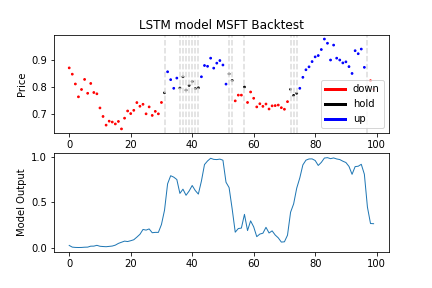

In [15]:
Image('train_lstm_backtest_1.png')

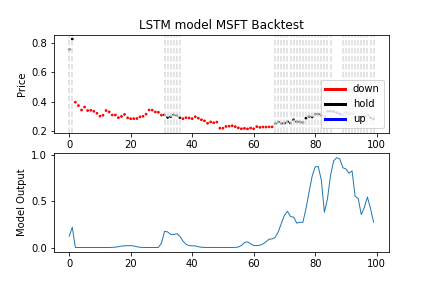

In [ ]:
Image('train_lstm_backtest_2.png')

Our strategy will be to...
- We are at a hold region it means that the model determines that trend is no longer strong. This is where we would need to make trade decision.
- If weighted average of past 5 days of model output was below 0.5 (in down trend) and if today's output is over 0.5, we Buy.
- If weighted average of past 5 days was above 0.5 (in up trend) and if today's output is below o.5, we Sell.

The parameters for backtest are...
- Margin : The range of model output that defines the "hold region".
- Risk : The amount to risk trading from 0 to 1. Higher the more trade volume. 

The profit at time t is calculated as below...

$$Profit(t) = \frac{(((inventory*price(t)) + cash(t)) - principal)}{principal}$$
In percentage it is Profit(t)*100


For example, if we were to trade starting for the first 500 days of our training data, we would end up with a -18.5% profit. If we would have go for buy and hold, we would get -61.5% profit.

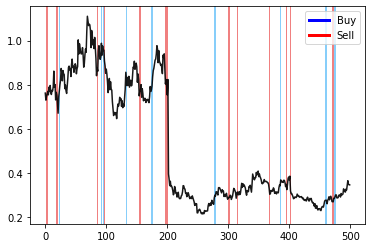

        Price Action trade Inventory    Profit  Buyhold_Profit
1    0.730621   Sell   857      5701 -0.020859       -0.041717
2    0.747024   Sell   562      5139 -0.011507       -0.020202
18   0.766277   Sell   985      4154 -0.001613        0.005051
19   0.752800   Sell  1516      2638 -0.007212       -0.012626
20   0.714294   Sell  1159      1479 -0.017369       -0.063131
23   0.773517    Buy  6413      7892 -0.008610        0.014545
84   0.841365   Sell  1951      5941  0.044935        0.103535
85   0.876483   Sell  1460      4481  0.065799        0.149596
92   0.988151    Buy   504      4985  0.115838        0.296061
94   0.976137    Buy  1494      6479  0.109849        0.280303
97   0.907750   Sell  3058      3421  0.065540        0.190606
132  0.856845    Buy  2703      6124  0.048126        0.123838
133  0.827888    Buy  2785      8909  0.030393        0.085859
153  0.824961   Sell   967      7942  0.027785        0.082020
154  0.749951   Sell  3930      4012 -0.031788       -0

In [59]:
#backtest_train = buysell_strat("lstm_model", X_train, P_train, 0.3, 10000, 1)
#backtest_train = squeeze_strat("lstm_model", X_train[0:500], P_train[0:500], [0.1,0.2,0.3,0.4], 8, 0.8, 0.4, 1000,'train')
train_backtest = hold_trade("lstm_model", Xs[0:500], prices[0:500], 0.4, 5, 10000. 0.5)
plot_backtest(train_backtest, "holdtrade_train")
print(train_backtest.loc[train_backtest['Action'] != "None"])



# Back-testing

Based on the strategy, we conduct back-test on the unseen 500 day test data set. Similar to the train data set, we see 

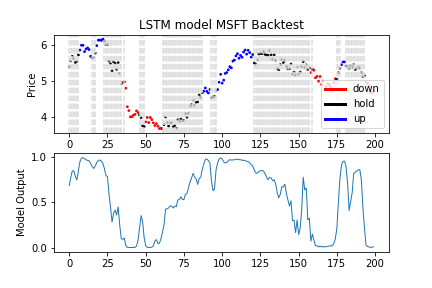

In [63]:
plot_output("lstm_model", "test", 0.4, Xs[2000:2200],prices[2000:2200])
Image('test_lstm_backtest_0.png')

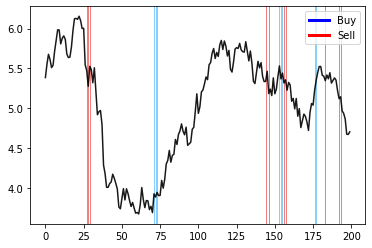

        Price Action trade Inventory    Profit  Buyhold_Profit
27   5.472222   Sell    69       859  0.007822        0.016189
28   5.275378   Sell   282       577 -0.009087       -0.020365
29   5.526439   Sell   106       471  0.005400        0.026257
71   3.923036    Buy    71       542 -0.070121       -0.271494
72   3.882370    Buy    80       622 -0.072325       -0.279046
73   3.941208    Buy   157       779 -0.068665       -0.268120
144  5.336988   Sell    49       730  0.040066       -0.008924
146  5.183270   Sell   221       509  0.028845       -0.037469
153  5.531060    Buy   572      1081  0.046547        0.027115
154  5.367793    Buy   169      1250  0.028898       -0.003203
155  5.441109    Buy   154      1404  0.038063        0.010411
156  5.316348   Sell   411       993  0.020546       -0.012757
157  5.356395   Sell   262       731  0.024523       -0.005320
176  5.223009    Buy     6       737  0.014772       -0.030090
177  5.346537    Buy   466      1203  0.023876       -0

In [60]:
#test_backtest = squeeze_strat("lstm_model", X_test, P_test, [0.1,0.2,0.3,0.4], 8, 0.8, 0.4, 1000, "test")
#backtest = buysell_strat("lstm_model", X_test, P_test, 0, 1000, 1)
test_backtest = hold_trade("lstm_model", Xs[2000:2200], prices[2000:2200], 0.4, 5, 10000, 0.5)

plot_backtest(test_backtest, "holdtrade_test")
print(test_backtest.loc[test_backtest['Action'] != "None"])

# Nested Cross Valdiation